<a href="https://colab.research.google.com/github/Bluseass/VKtest/blob/main/VK%D1%81%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('/content/drive/MyDrive/VK/train_spam.csv')

#Аналитика данных и графики

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#посмотрим на данные (сразу видно что нет заглавных букв/грамматики)
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [5]:
#посмотрим на размер датасета (16278, 2)
print(df.shape)

(16278, 2)


In [6]:
#проверю пропуски (их нет - это хорошо не нужно заполнять ничего)
print(df.isnull().sum())

text_type    0
text         0
dtype: int64


text_type
ham     11469
spam     4809
Name: count, dtype: int64


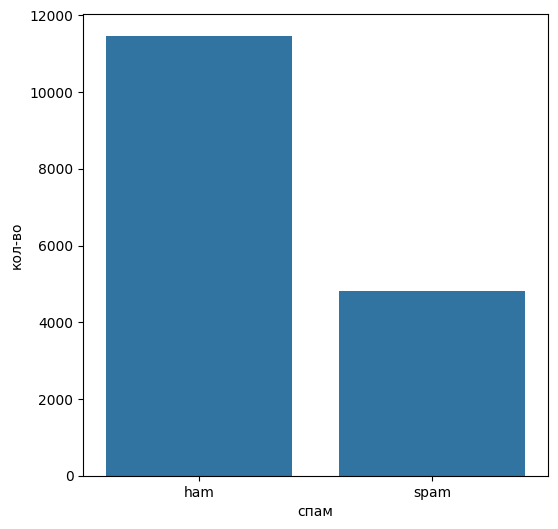

In [7]:
#подсчитаю кол-во классов
spam_count = df['text_type'].value_counts()
print(spam_count)
#сделаю график
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='text_type')
plt.xlabel('спам')
plt.ylabel('кол-во')
plt.show()

Учитывая дисбаланс классов, при разработке модели для определения спама необходимо уделить особое внимание обработке этого дисбаланса. Это может включать в себя использование методов взвешивания классов, аугментации данных или выбора подходящих метрик оценки качества модели, способных учитывать дисбаланс.

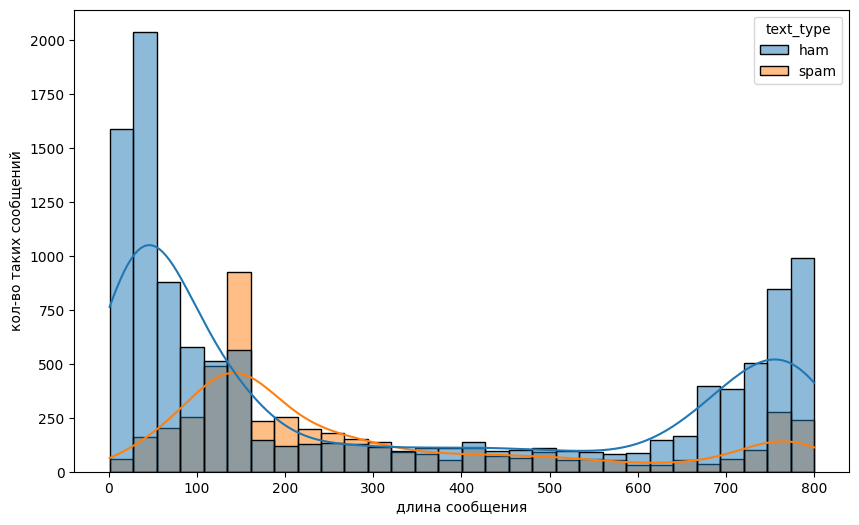

In [8]:
# Вычисляем длину каждого сообщения
df['length'] = df['text'].apply(len)

# Построим гистограмму
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='text_type', bins=30, kde=True)
plt.xlabel('длина сообщения')
plt.ylabel('кол-во таких сообщений')
plt.show()

В основном ham сообщения или очень короткие или очень длинные, а вот spam сосредоточен нп 50-300 символах

#Предобработка данных

In [9]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


nltk.download('stopwords')
ps = PorterStemmer()
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_textTFIDF)
X_tfidf = tfidf_vect.fit_transform(df['text'])
X_features = pd.concat([df['length'], pd.DataFrame(X_tfidf.toarray())], axis=1)

#Модели

добавление фичи "длинна сообщения", лишь ухудшает результаты.

 **Мультиномиальный наивный Байес**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import aroc_auc_score

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['text_type'], test_size=0.2, random_state=42)
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)

clf = MultinomialNB()
clf.fit(X_train_counts, y_train)

X_test_counts = vectorizer.transform(X_test)

#получение вероятностей
y_pred_proba = clf.predict_proba(X_test_counts)

#кодирование меток
y_test_binary = y_test.apply(lambda x: 1 if x == 'spam' else 0)

#ROCAUC
roc_auc = roc_auc_score(y_test_binary, y_pred_proba[:, 1])
print("ROCAUC: ", roc_auc)


ROC AUC Score:  0.9637835895001924


**регрессия + bag of words // если использовать функцию clean text то точно будет ROC AUC Score: 0.9768, что ниже чем без.**

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

data = pd.read_csv("/content/drive/MyDrive/VK/train_spam.csv")
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['text_type'], test_size=0.2, random_state=42)

#TFIDF
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

#обучение логистической регрессии
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

#получение вероятностей
y_pred_proba = model.predict_proba(X_test_tfidf)

#ROCAUC
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print("ROCAUC:", roc_auc)

ROC AUC Score: 0.9788047748181564


**Bert** ну времени обучать (дообучать) в данный момент нету, но, вероятно, там будут очень хорошие результаты.

In [22]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.metrics import roc_auc_score
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [23]:
data = pd.read_csv("/content/drive/MyDrive/VK/train_spam.csv")
def clean_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = re.split('\W+', text)
    ps = PorterStemmer()
    text = [ps.stem(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(text)

data['text'] = data['text'].apply(clean_text)

In [40]:
#разделение данных
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['text_type'], test_size=0.2, random_state=42)

#преобразование меток числовой формат
label_map = {'spam': 1, 'ham': 0}
train_labels = torch.tensor([label_map[label] for label in y_train])
test_labels = torch.tensor([label_map[label] for label in y_test])

In [26]:
#загрузка обученного токенизатора DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [32]:
#токенизация текста
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

In [33]:
#создание DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              train_labels)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
#загрузка обученной модели
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [ ]:
#оптимизатор
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from sklearn.metrics import roc_auc_score

#обучение
model.train()

roc_aucs = []
epochs = 3

for epoch in range(epochs):
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    #оценка
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted = torch.argmax(outputs.logits, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.logits[:, 1].cpu().numpy())
    roc_auc = roc_auc_score(y_true, y_pred)
    roc_aucs.append(roc_auc)
    print(f"Epoch {epoch + 1}/{epochs}, ROCAUC: {roc_auc:.4f}")

#график ROCAUC
plt.plot(roc_aucs)
plt.xlabel('эпохи')
plt.ylabel('ROCAUC')
plt.show()

**случайные леса**

In [41]:
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(df['text'], df['text_type'], test_size=0.2, random_state=42)

#преобразование в векторы bag of words
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

#обучение случайного леса
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_counts, y_train)
y_pred_proba_rf = rf.predict_proba(X_test_counts)

#ROCAUC
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf[:, 1])
print("ROCAUC:", roc_auc_rf)

Random Forest ROC AUC Score: 0.9833759190096468


**градиентный бустинг**

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['text_type'], test_size=0.2, random_state=42)

#преобразование в векторы bag of words
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

#обучение градиентного бустинга
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_counts, y_train)
y_pred_proba_gb = gb.predict_proba(X_test_counts)

#ROCAUC
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb[:, 1])
print("ROCAUC:", roc_auc_gb)

ROCAUC: 0.9477403479507034


**cat boost ----- ROCAUC: 0.9783981180894277**

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

#CatBoost
catboost_model = CatBoostClassifier(iterations=100, verbose=0, random_state=42)
catboost_model.fit(X_train_counts, y_train)
y_pred_proba_catboost = catboost_model.predict_proba(X_test_counts)

#ROCAUC
roc_auc_catboost = roc_auc_score(y_test, y_pred_proba_catboost[:, 1])
print("ROCAUC:", roc_auc_catboost)

**XGBoost ----- ROCAUC: 0.9760305234466982**

In [50]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

#преобразование
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#XGBoost
xgboost_model = XGBClassifier(n_estimators=100, random_state=42)
xgboost_model.fit(X_train_counts, y_train_encoded)
y_pred_proba = xgboost_model.predict_proba(X_test_counts)

from sklearn.metrics import roc_auc_score

#ROCAUC
roc_auc_xgboost = roc_auc_score(y_test_encoded, y_pred_proba[:, 1])
print("ROCAUC:", roc_auc_xgboost)

ROC AUC Score for XGBoost: 0.9760305234466982


**SVM (опорные вектора) ---- 0.9788596101164214**

In [51]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd


data = pd.read_csv("/content/drive/MyDrive/VK/train_spam.csv")
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['text_type'], test_size=0.2, random_state=42)

#векторизация
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

#svm
svm_model = SVC(probability=True)
svm_model.fit(X_train_counts, y_train)
y_pred_proba = svm_model.predict_proba(X_test_counts)

#ROCAUC
roc_auc_svm = roc_auc_score(y_test, y_pred_proba[:, 1])
print("ROCAUC:", roc_auc_svm)

ROC AUC Score for SVM: 0.9788596101164214


#Проверка на Test

лучшая модель судя по всему случайные леса (0.983) ну или bert, который не был обучен

In [53]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer


test_data = pd.read_csv("/content/drive/MyDrive/VK/test_spam.csv")
X_test_counts = vectorizer.transform(test_data['text'])
y_pred_proba_rf_test = rf.predict_proba(X_test_counts)

#создание df для ответов
results_df = pd.DataFrame({
    'score': y_pred_proba_rf_test[:, 1],
    'text': test_data['text']
})

#сохраняю в csv
results_df.to_csv("/content/drive/MyDrive/VK/results.csv", index=False)

In [54]:
results_df = pd.read_csv("/content/drive/MyDrive/VK/results.csv")
binary_scores = [1 if score >= 0.5 else 0 for score in results_df['score']]
binary_results_df = pd.DataFrame({
    'score': binary_scores,
    'text': results_df['text']
})
binary_results_df.to_csv("/content/drive/MyDrive/VK/binar_results.csv", index=False)